In [1]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import TQDMProgressBar

import torch
from torch.utils.data import TensorDataset, DataLoader
from src.model_specpred import SpectrumPredictor
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float64)

/Users/zhantaochen/opt/anaconda3/envs/admb/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = torch.load("data/CrI3/20221110.pt")
X = data['param'][:,:2]
Y = torch.cat((data['omega'], data['inten']), dim=1)

X_train, X_val_test, Y_train, Y_val_test = train_test_split(X, Y, test_size=8/10, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_test, Y_val_test, test_size=1/2, random_state=42)

print("print some values for further reference:")
print("training:\n", X_train[:5])
print("validation:\n", X_val[:5])
print("testing:\n", X_test[:5])

train_dataset = TensorDataset(X_train, Y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(X_val, Y_val)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print some values for further reference:
training:
 tensor([[-2.6756, -0.2057],
        [-1.0074, -0.8722],
        [-1.4652, -0.3473],
        [-1.9456, -0.8723],
        [-1.0767, -0.4294]])
validation:
 tensor([[-1.3288, -0.7558],
        [-2.7176, -0.3953],
        [-2.4942, -0.3290],
        [-2.7871, -0.9420],
        [-2.8615, -0.5053]])
testing:
 tensor([[-1.9341, -0.6214],
        [-1.4045, -0.4092],
        [-2.5118, -0.0429],
        [-1.4161, -0.0631],
        [-1.0095, -0.7882]])


In [3]:
model_spec = SpectrumPredictor(num_param_in=X.shape[1], num_mode=2)

In [4]:
from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    save_on_train_epoch_end=False, save_last=True, save_top_k=1, monitor="val_loss"
)

trainer = pl.Trainer(
    max_epochs=10000, accelerator="cpu",
    callbacks=[checkpoint_callback, TQDMProgressBar(refresh_rate=2)],
    log_every_n_steps=2, devices=1, 
    enable_checkpointing=True,
    default_root_dir="training_logs"
    )

trainer.fit(model_spec, train_dataloader, val_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | fc_net | Sequential | 42.2 K
--------------------------------------
42.2 K    Trainable params
0         Non-trainable params
42.2 K    Total params
0.169     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/zhantaochen/opt/anaconda3/envs/admb/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/Users/zhantaochen/opt/anaconda3/envs/admb/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 2154:  60%|██████    | 12/20 [00:00<00:00, 160.47it/s, loss=0.00258, v_num=4]

/Users/zhantaochen/opt/anaconda3/envs/admb/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [5]:
model_spec.load_from_checkpoint("training_logs/lightning_logs/version_52/checkpoints/epoch=713-step=17850.ckpt")

SpectrumPredictor(
  (fc_net): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=4, bias=False)
  )
)

In [10]:
Y_val_pred = []
with torch.no_grad():
    for x_val in X_val:
        Y_val_pred.append(model_spec(x_val.to(model_spec.device)).detach())
Y_val_pred = torch.vstack(Y_val_pred).cpu()

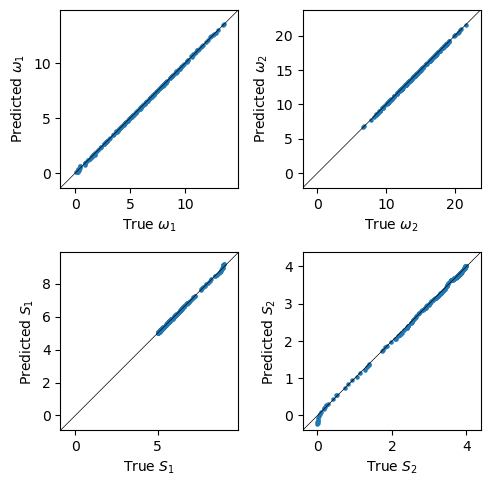

In [11]:
labels = ['$\omega_1$', '$\omega_2$', '$S_1$', '$S_2$']

fig = plt.figure(figsize=(5,5))
gs = plt.GridSpec(2,2)
for i in range(4):
    ax = fig.add_subplot(gs[i])
    ax.plot([-100,100], [-100,100], 'k', linewidth=0.5)
    ax.scatter(Y_val[:,i], Y_val_pred[:,i], s=5)
    ax.set_aspect('equal')
    ax.set_xlim([-0.1*Y_val[:,i].max(), 1.1*Y_val[:,i].max()])
    ax.set_ylim([-0.1*Y_val[:,i].max(), 1.1*Y_val[:,i].max()])
    ax.set_xlabel(f"True {labels[i]}")
    ax.set_ylabel(f"Predicted {labels[i]}")

fig.tight_layout()

In [38]:
x_val = X_val[0]
y_val_pred = model_spec(x_val)

In [39]:
y_val_pred

tensor([ 6.1968, 16.1807,  5.2981,  3.7198], grad_fn=<SqueezeBackward3>)